In [1]:
# importing all necessary libraries.
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tkinter import *
from tkinter import filedialog
import tkinter as tk
from tkinter import messagebox

In [2]:
regressor = Sequential()

In [3]:
def doTrain():
    global regressor,e2,data2,sc
    stkname=e2.get()
    #stkname='SBIN'
    # fetching training data 
    start = dt.datetime(2013,1,1)
    end = dt.datetime(2018,12,31)
    stk_data = gh(symbol=stkname,start=start,end=end)
    # data preprocessing 
    stk_data['Date'] = stk_data.index
    data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
    print('************** Downloaded data **************');
    
    data2['Date'] = stk_data['Date']
    data2['Open'] = stk_data['Open']
    data2['High'] = stk_data['High']
    data2['Low'] = stk_data['Low']
    data2['Close'] = stk_data['Close']

    print(data2.head(10))
    print('*************** Closing price **************');
    print(data2['Close'][0:10]); 
    

    # feature extraction
    train_set = data2.iloc[:, 1:2].values
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(train_set)
    X_train = []
    y_train = []
    #for i in range(60, 1482):
    for i in range(60, len(training_set_scaled)):
        X_train.append(training_set_scaled[i-60:i, 0])
        y_train.append(training_set_scaled[i, 0]) 
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    print('*************** Training set **************');
    print(X_train[:10])

    #creating the LSTM model 
    regressor = Sequential()
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))


    #training the LSTM model 
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    regressor.fit(X_train, y_train, epochs = 25, batch_size = 32)

    messagebox.showinfo("Training", "Trainign completed")
    

In [4]:
def doPredict():
    global regressor,e2,e3,e4,data2,sc

    stkname=e2.get()
    fromdates=e3.get()
#     todates=e4.get()
    test_dates = dt.datetime.now()
    
    
    fdparts=fromdates.split("-")
    fyy=int(fdparts[0].strip())
    fmm=int(fdparts[1].strip())
    fdd=int(fdparts[2].strip())

#     fdparts=todates.split("-")
#     syy=int(fdparts[0].strip())
#     smm=int(fdparts[1].strip())
#     sdd=int(fdparts[2].strip())

    print('From is <',fyy,'><',fmm,'><',fdd,'>')
    
    print(f'To is :{test_dates}')

#     print('To is <',syy,'><',smm,'><',sdd,'>')
     
    #fyy=2019
    #fmm=1
    #fdd=1

    #syy=2019
    #smm=9
    #sdd=18
    
    # Fetching the test data 
    testdataframe= gh(symbol=stkname,start=dt.datetime(fyy,fmm,fdd),end= test_dates)
    testdataframe['Date'] = testdataframe.index
    testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
    testdata['Date'] = testdataframe['Date']
    testdata['Open'] = testdataframe['Open']
    testdata['High'] = testdataframe['High']
    testdata['Low'] = testdataframe['Low']
    testdata['Close'] = testdataframe['Close']
    real_stock_price = testdata.iloc[:, 1:2].values
    dataset_total = pd.concat((data2['Open'], testdata['Open']), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    X_test = []
    #for i in range(60, 235):
    for i in range(60, len(inputs)):
        X_test.append(inputs[i-60:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


    # predicting the price. 
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    
    #Predict Next Day

    #real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1), 0]]
    real_data = [inputs[len(inputs)-60:len(inputs+1), 0]]
    real_data = np.array(real_data)
    real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

    prediction = regressor.predict(real_data)
    prediction = sc.inverse_transform(prediction)
    nxt_day = print(f"Next Day's Predicted Price: {prediction}")

    # Plotting the comparison of actual and predicted price. 
    plt.figure(figsize=(20,10))
    plt.plot(real_stock_price, color = 'green', label = f'{stkname} Stock Price')
    plt.plot(predicted_stock_price, color = 'red', label = f'Predicted {stkname} Stock Price')
#     plt.plot(nxt_day, color= 'blue', label = f'Next Day Predicted Price')
    plt.text(-5, 60, f"Next Day's Predicted Price: {nxt_day}", fontsize = 22)
    plt.title(f'{stkname} Stock Price Prediction')
    plt.xlabel('Trading Day')
    plt.ylabel(f'{stkname} Stock Price')
    plt.legend()
    plt.show()


************** Downloaded data **************
                  Date     Open     High      Low    Close
Date                                                      
2013-01-01  2013-01-01  1266.95  1267.90  1260.00  1264.15
2013-01-02  2013-01-02  1267.00  1272.40  1255.55  1263.30
2013-01-03  2013-01-03  1265.00  1284.00  1259.95  1280.60
2013-01-04  2013-01-04  1285.00  1301.00  1280.90  1299.20
2013-01-07  2013-01-07  1300.00  1304.00  1290.25  1294.85
2013-01-08  2013-01-08  1295.00  1304.30  1294.30  1300.25
2013-01-09  2013-01-09  1301.00  1307.40  1273.15  1276.60
2013-01-10  2013-01-10  1279.90  1282.10  1255.30  1258.40
2013-01-11  2013-01-11  1290.00  1322.50  1290.00  1306.35
2013-01-14  2013-01-14  1319.00  1348.45  1307.35  1334.50
*************** Closing price **************
Date
2013-01-01    1264.15
2013-01-02    1263.30
2013-01-03    1280.60
2013-01-04    1299.20
2013-01-07    1294.85
2013-01-08    1300.25
2013-01-09    1276.60
2013-01-10    1258.40
2013-01-11    1306.3

Epoch 1/25
45/45 [==============================] - 8s 72ms/step - loss: 0.0227
Epoch 2/25
45/45 [==============================] - 3s 76ms/step - loss: 0.0074
Epoch 3/25
45/45 [==============================] - 3s 71ms/step - loss: 0.0067
Epoch 4/25
45/45 [==============================] - 3s 70ms/step - loss: 0.0058
Epoch 5/25
45/45 [==============================] - 3s 70ms/step - loss: 0.0055
Epoch 6/25
45/45 [==============================] - 3s 70ms/step - loss: 0.0051
Epoch 7/25
45/45 [==============================] - 3s 69ms/step - loss: 0.0053
Epoch 8/25
45/45 [==============================] - 3s 69ms/step - loss: 0.0053
Epoch 9/25
45/45 [==============================] - 3s 71ms/step - loss: 0.0050
Epoch 10/25
45/45 [==============================] - 3s 70ms/step - loss: 0.0050
Epoch 11/25
45/45 [==============================] - 3s 69ms/step - loss: 0.0045
Epoch 12/25
45/45 [==============================] - 3s 69ms/step - loss: 0.0044
Epoch 13/25
45/45 [==================

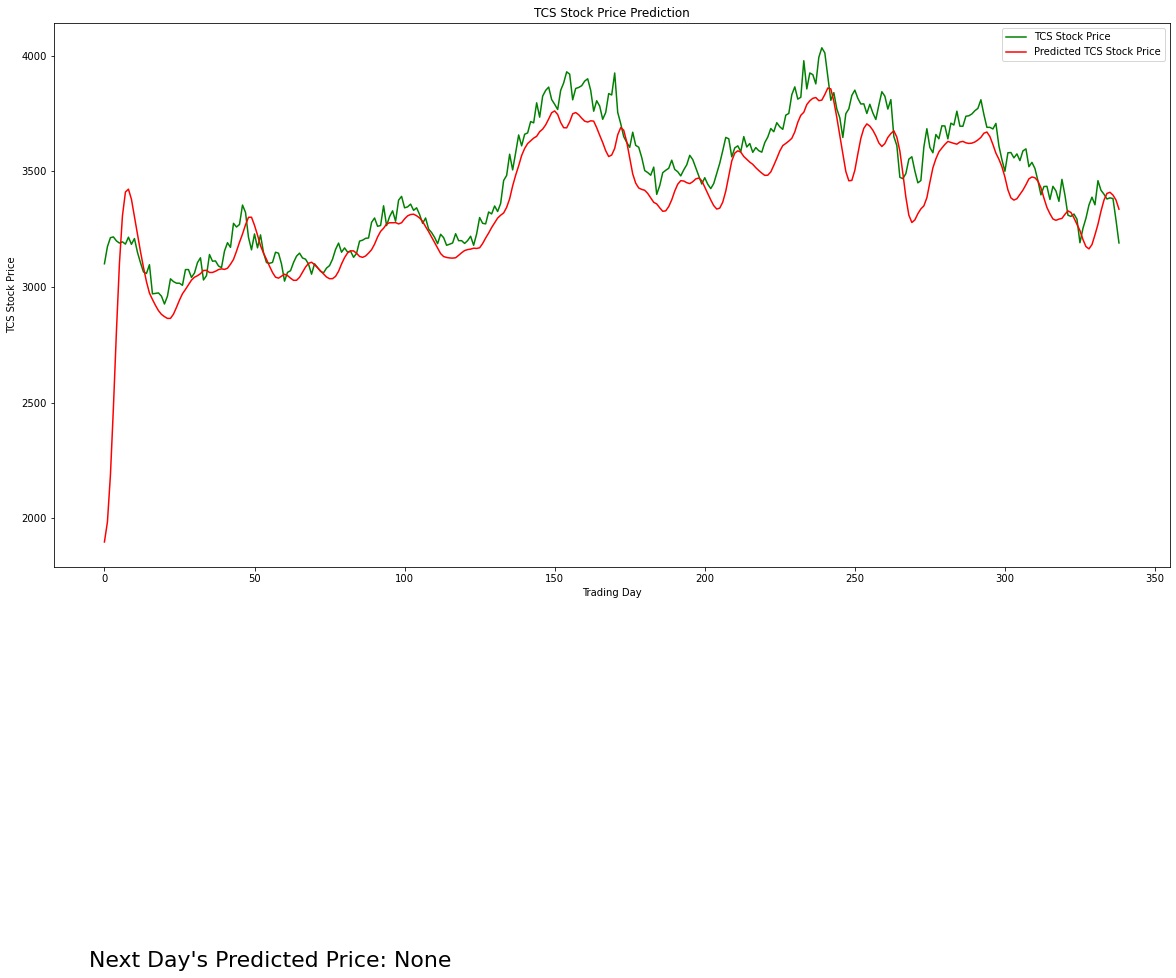

In [ ]:
import PIL.Image


if __name__ == "__main__":
    global parent
       
    global e2,e3,variable
#e4,
    
    parent = tk.Tk()
    parent.geometry("800x500")
    parent.configure(bg='black')
    parent.title("Stock Market prediction")
    frame = tk.Frame(parent)
    frame.pack()

    #image2 =Image.open('./back.jpg')
    fp = open('./back.jpg',"rb")
    image2=PIL.Image.open(fp);
    import PIL.ImageTk       
    image1 = PIL.ImageTk.PhotoImage(image2)

    your_label = Label(master=parent, image=image1)
    your_label.place(x=0, y=0, relwidth=1, relheight=1)
    your_label.pack()

    w = tk.Label(frame, text="Stock market prediction",
                     fg = "red",
                     font = ("Times New Roman", 18))
    w.pack()


    w=tk.Label(frame, 
             text="Stock script Name")
    w.pack()

    e2 = tk.Entry(frame)
    e2.pack()

     


    text_disp= tk.Button(frame,
                         fg = "red",
                       text="TRAIN", 
                       command=doTrain
                       )
    text_disp.pack()


    w=tk.Label(frame, 
             text="From data(yyyy-mm-dd)")
    w.pack()

    e3 = tk.Entry(frame)
    e3.pack()

#     w=tk.Label(frame, 
#              text="To date(yyyy-mm-dd")
#     w.pack()

#     e4 = tk.Entry(frame)
#     e4.pack()
    

    text_disp= tk.Button(frame,
                         fg = "red",
                       text="PREDICT", 
                       command=doPredict
                       )
    text_disp.pack()

    parent.mainloop()
